# Import packages

In [2]:
%load_ext autoreload
%autoreload 2
from XRR.utilities.math import shift_with_power # used to shift reflectivities vertically in plot for better visibility
from XRR.utilities.conversion_methods import kev2angst, th2q # convert energy to wavelength and angle of incidence to momentum transfer (units are degree and angstrom)
from XRR.read_data.DELTA_BL9 import einlesenDELTA as DELTA # class to read the data
from XRR.plotly_layouts import plotly_layouts as layouts, col_row_list, create_colormap # layout stuff for plotting
from XRR import XRR_analysis as XRRa
import numpy as np
import pandas as pd

layouts = layouts()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


c:\users\mikem\documents\github\xrr\src\XRR\utilities\file_operations.py:43: SyntaxWarning: invalid escape sequence '\s'
  data = read_csv(file, header=header_len, sep='\s+', names = colnames, usecols = colnames)
c:\users\mikem\documents\github\xrr\src\XRR\utilities\file_operations.py:61: SyntaxWarning: invalid escape sequence '\s'
  datfileData = read_csv(data_file, header = None, sep = '\s+', names = colnames)


ModuleNotFoundError: No module named 'pymol'

# Create layer stack and perfrom some calculations
For this example the layer stack consists of a Tantal substrate, covered by an oxide layer. On top of the oxide layer there is a copper nitride film. The layer stack is in vacuum.<br>
layer parameters are assumed reasonably.

In [24]:
wavelength = kev2angst(8)
angle_of_incidence = np.linspace(0, 4, num  = 200)
momentum_transfer = th2q(wavelength, angle_of_incidence)

# dispersion and absorption values taken from "https://henke.lbl.gov/optical_constants/"
disp_sub, disp_Ta2O5, disp_Cu3N = 3.98283992E-05, 2.08493475E-05, 2.47275948E-05
a_sub, a_Ta2O5, a_Cu3N = 3.23136237E-06,1.32327057E-06, 5.17534545E-07
# layer thicknesses and roughnesses are assumed
thickness_sub, thickness_Ta2O5, thickness_Cu3N = np.inf, 10, 60
roughness_sub, roughness_Ta2O5, roughness_Cu3N, roughness_vac = 0, 6, 8, 10
# create layers
substrate_layer = XRRa.layer(disp_sub, a_sub, thickness_sub, roughness=roughness_sub)
Ta2O5_layer = XRRa.layer(disp_Ta2O5, a_Ta2O5, thickness_Ta2O5, roughness = roughness_Ta2O5)
Cu3N_layer = XRRa.layer(disp_Cu3N, a_Cu3N, thickness_Cu3N, roughness=roughness_Cu3N)
vacuum_layer = XRRa.layer(0,0,0,roughness=roughness_vac)

## Simulate reflectivity of layer stack and plot result

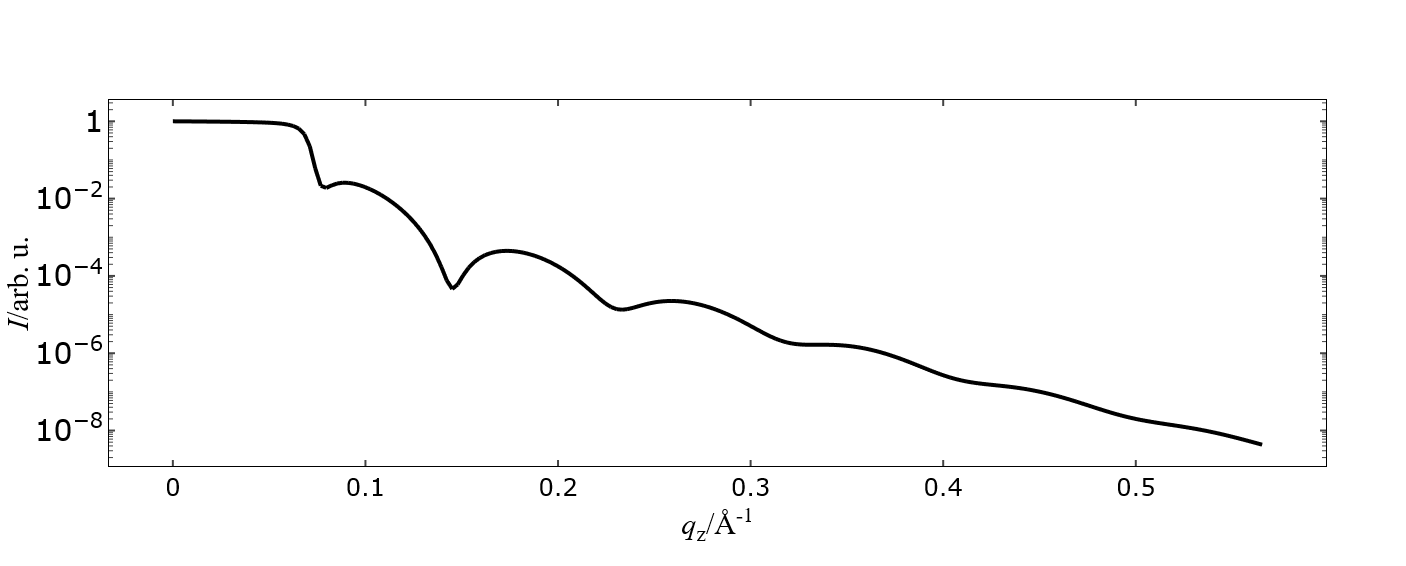

0.012440093001714558 seconds.


In [59]:
laystack = XRRa.refl_multiple_layers(momentum_transfer, [substrate_layer, Ta2O5_layer, Cu3N_layer, vacuum_layer], wavelength, ind_of_refrac_profile='tanh', alpha_i_unit='Ae-1')
refl_laystack = laystack.calculate_specular_reflectivity(plot = True)

## Normalize to Fresnel reflectivity

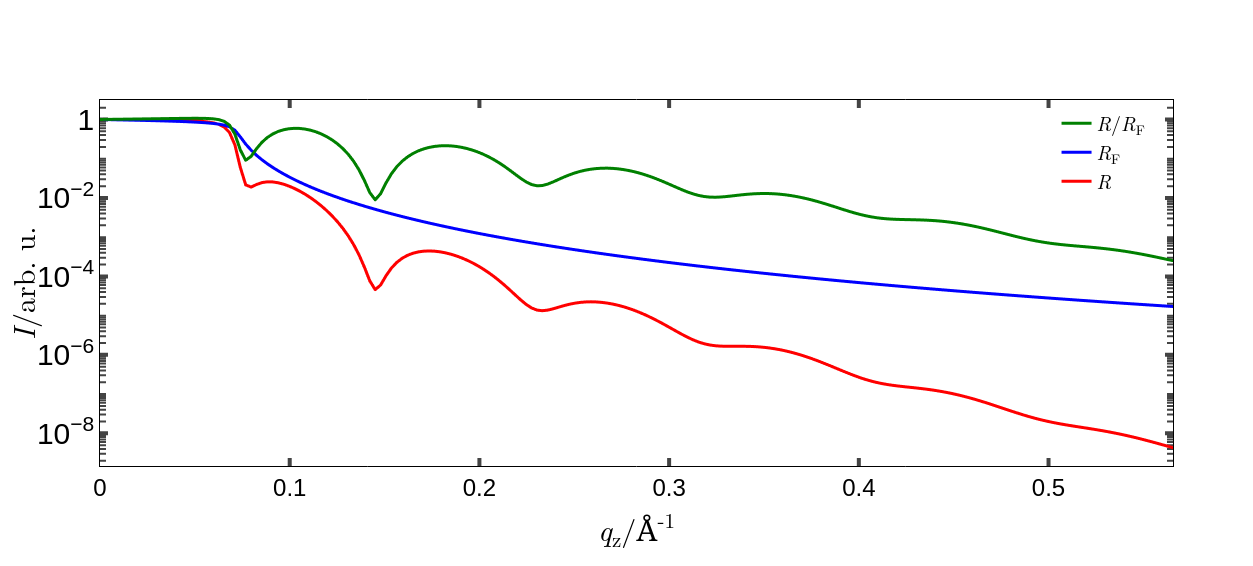

In [58]:
# calculate Fresnel reflectivtiy
alpha_red, fresnel_refl = XRRa.single_layer_simulations(angle_of_incidence*np.pi/180, wavelength, disp_sub, a_sub).Fresnel_Refl()

# normalize reflectivity of layer stack
normalized_refl = refl_laystack/fresnel_refl
# create traces for plotting
trace_normalized_refl = go.Scattergl(x = momentum_transfer, y = normalized_refl, mode = 'lines', line = dict(width = 3, color = 'green'), name = '<i>R</i>/<i>R</i><sub>F</sub>')
trace_refl = go.Scattergl(x = momentum_transfer, y = refl_laystack, mode = 'lines', line = dict(width = 3, color = 'red'), name = '<i>R</i>')
trace__fresnel_refl = go.Scattergl(x = momentum_transfer, y = fresnel_refl, mode = 'lines', line = dict(width = 3, color = 'blue'), name = '<i>R</i><sub>F</sub>')
# create figure and plot
fig = go.Figure(data = [trace_refl, trace__fresnel_refl, trace_normalized_refl], layout=layouts.refl())
fig.update_layout(legend_traceorder = 'reversed')
fig.show()

## Calculate electron density profile from reflectivity using the Effective Density Model

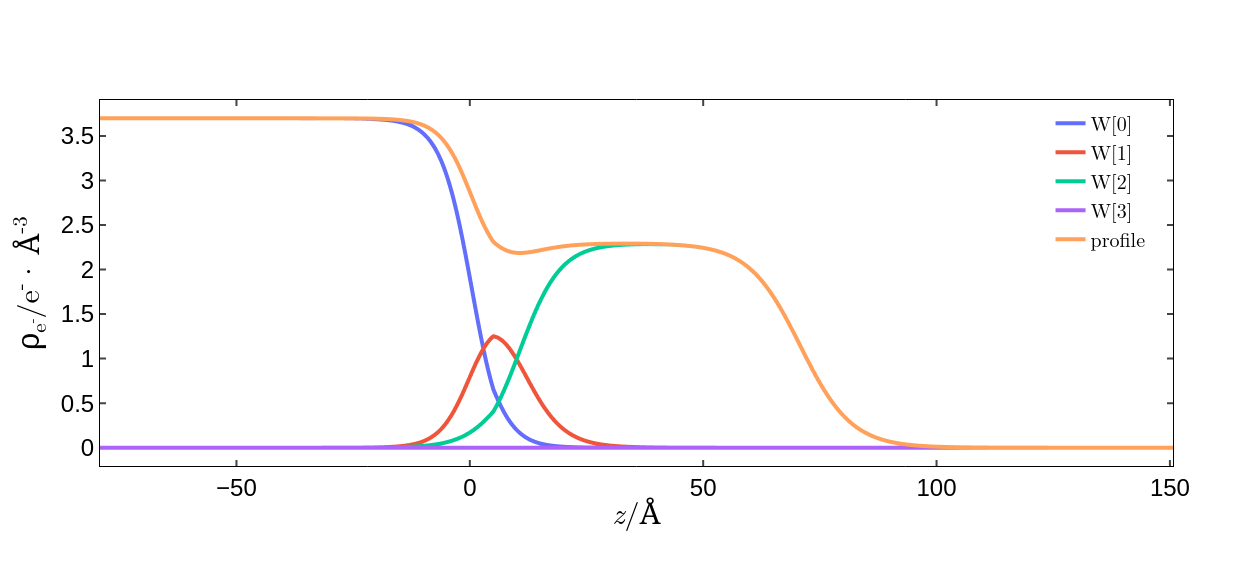

In [33]:
electron_density_data = laystack.EffectiveDensitySlicing()
electron_density_data['fig_disp_profile'].show()